In [8]:
import re
import gensim
import logging
import pandas as pd
import urllib.request
from gensim.models import word2vec

In [20]:
def get_Model():  # скачивает с rus_vectores модель
    req = urllib.request.urlretrieve('http://rusvectores.org/static/models/rusvectores2/'
                                     'ruscorpora_mystem_cbow_300_2_2015.bin.gz',
                                     'ruscorpora_mystem_cbow_300_2_2015.bin.gz')
    return

get_Model()

In [9]:
def make_Model():  # делает для скачанной модели word2vec
    m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'
    if m.endswith('.bin.gz'):  # делает вектора
        model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
    return model

In [36]:
import networkx as nx

def create_Graph(model):  # ищет слова и близкие к ним в модели
    start_words = ["театр_S", "сцена_S", "актер_S"]
    G = nx.Graph() # пустой граф
    G.add_nodes_from(start_words) # добавляем несколько узлов сразу
    # по модели ищем слова первого порядка для каждого слова списка
    for word in start_words:
        par_speech = re.search(r'_([A-Za-z]+)', word)
        morpho = par_speech.group(1)
        if word in model:
            print(word)
            print(model[word][:10])
            print("--------------")
            for i in model.most_similar(positive=[word], topn=15):
                par_speech2 = re.search(r'_([A-Za-z]+)', i[0])
                morpho2 = par_speech2.group(1)
                if i[1] >= 0.5 and morpho == morpho2:
                    print(i[0], i[1])
                    print("(())")
                  #  G.add_node(i[0])
                    G.add_edge(word, i[0])
                    if i[0] in model:
                        print(i[0])
                        print(model[i[0]][:10])
                        for el in model.most_similar(positive=[i[0]], topn=15):
                            par_speech3 = re.search(r'_([A-Za-z]+)', el[0])
                            morpho3 = par_speech3.group(1)
                            if el[1] >= 0.5 and morpho2 == morpho3:
                                print(el[0], el[1])
                              #  G.add_node(el[0])
                                G.add_edge(i[0], el[0])
            print('\n')
    #pos = nx.spring_layout(G)
    #nx.draw_networkx_nodes(G, pos, node_color='green', node_size=100)
    #nx.draw_networkx_edges(G, pos, edge_color='yellow')
    #nx.draw_networkx_labels(G, pos, font_size=20, font_family='Arial')
    #plt.axis('off')
    #plt.show()
    return G

In [37]:
from networkx.algorithms import community

def analysis(G):
    print("Число узлов: ", G.number_of_nodes())
    print("Число ребер: ", G.number_of_edges())
    # Радиус графа, минимальный эксцентриситет среди всех вершин графа
    print("Радиус графа: ", nx.radius(G))

# Диаметр графа, самый длинный путь от одной вершины до другой
    print("Диаметр графа: ", nx.diameter(G))

# Коэффициент ассортативности (насколько вся сеть завязана на основных "хабах"):
    print("Коэффициент ассортативности: ", nx.degree_pearson_correlation_coefficient(G))
    
    print("Коэфициент классетризации: ", nx.average_clustering(G))

# Плотность графа, отношение рёбер и узлов
    print("Плотность графа: ", nx.density(G))
    
    deg_cen = nx.degree_centrality(G)
    for nodeid in sorted(deg_cen, key=deg_cen.get, reverse=True)[:3]:
        print("Центральность узлов по degree centrality: ", nodeid)
    bet_cen = nx.betweenness_centrality(G)
    for nodeid in sorted(bet_cen, key=bet_cen.get, reverse=True)[:3]:
        print("Центральность узлов по betweenness centrality: ", nodeid)
    clos_cen = nx.closeness_centrality(G)
    for nodeid in sorted(clos_cen, key=clos_cen.get, reverse=True)[:3]:
        print("Центральность узлов по closeness centrality: ", nodeid)
    eig_cen = nx.eigenvector_centrality(G)
    for nodeid in sorted(eig_cen, key=eig_cen.get, reverse=True)[:3]:
        print("Центральность узлов по eigenvector centrality: ", nodeid)

In [38]:
import random
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

def groups(G):
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    comm = sorted(map(sorted, next_level_communities))
    for group in comm:
        print(group)
    pos = nx.spring_layout(G)
    colors = ["lavender", "aqua", "wheat", "teal", "lightblue", "coral"]
  #  for group in comm:
  #      gr_color = random.choice(colors)
    plt.figure(figsize=(15, 15), dpi=200)
    nx.draw_networkx_nodes(G, pos, comm[0], node_color="wheat", node_size=100) 
    nx.draw_networkx_nodes(G, pos, comm[1], node_color="teal", node_size=100) 
    nx.draw_networkx_nodes(G, pos, comm[2], node_color="lightblue", node_size=100) 
    nx.draw_networkx_edges(G, pos, edge_color='yellow')
    plt.axis('off')
    plt.show()
   # return comm

Сообщества:


    к первой группе относятся все, что связано с жанровой программ в театре, места, в которых эти жанры реализуются
    
    ко второй - люди, которые работают на благо театра и всего, что с ним связано
      
    к третьей - атрибутика театрального выступления: все мелкие детали, прогоны, роли и тому подобное

In [51]:
import random
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

def design_Graph(G, comm):
    pos = nx.spring_layout(G)
    colors = ["lavender", "aqua", "wheat", "teal", "lightblue", "coral"]
  #  for group in comm:
  #      gr_color = random.choice(colors)
    plt.figure(figsize=(25, 25), dpi=200)
    nx.draw_networkx_nodes(G, pos, comm[0], node_color="wheat", node_size=100) 
    nx.draw_networkx_nodes(G, pos, comm[1], node_color="teal", node_size=100) 
    nx.draw_networkx_nodes(G, pos, comm[2], node_color="lightblue", node_size=100) 
    nx.draw_networkx_edges(G, pos, edge_color='yellow')
  #  nx.draw_networkx_edges(G, pos, comm[0], edge_color="wheat") 
  #  nx.draw_networkx_edges(G, pos, comm[1], edge_color="teal") 
  #  nx.draw_networkx_edges(G, pos, comm[2], edge_color="lightblue") )
    nx.draw_networkx_labels(G, pos, font_size=15, font_family='Arial')
    plt.axis('off')
    plt.show()

театр_S
[ 0.05735958  0.02279772 -0.01869367  0.04660577  0.04590354  0.03536589
 -0.01915302  0.08155805  0.0798835   0.07132304]
--------------
мхат_S 0.6755560636520386
(())
мхат_S
[ 0.01414966 -0.00357031  0.02065288  0.0748034   0.03701768  0.05863323
  0.03788952  0.06932685  0.1213202   0.08528609]
театр_S 0.6755560636520386
ленком_S 0.6143943667411804
мейерхольд_S 0.5727198719978333
тюз_S 0.5612602233886719
эфрос_S 0.5495337843894958
спектакль_S 0.5440467000007629
студия_S 0.5411021709442139
вахтангов_S 0.5271117091178894
таировский_S 0.5192093253135681
труппа_S 0.5108367800712585
труппа_S 0.6605667471885681
(())
труппа_S
[ 0.0115323   0.02689098 -0.00630232 -0.0549786   0.04597765 -0.00610664
 -0.03454065  0.01586888  0.11768788  0.07008183]
театр_S 0.6605667471885681
спектакль_S 0.6128294467926025
репертуар_S 0.5814101696014404
актер_S 0.5783778429031372
ленком_S 0.531975269317627
артист_S 0.5289832949638367
студия_S 0.5210974812507629
оперетта_S 0.5132284760475159
опера_S 0.

трагедия_S 0.7897323369979858
комедия_S 0.6674702763557434
пьеса_S 0.6249310970306396
мелодрама_S 0.6129873394966125
сюжет_S 0.5827673673629761
водевиль_S 0.5743041634559631
эпопея_S 0.5361365079879761
сцена_S 0.5348637104034424
трагикомедия_S 0.531484842300415
мистерия_S 0.5131040215492249
фарс_S 0.5127328634262085
спектакль_S 0.507194995880127
гамлет_S 0.5067827105522156
роман_S 0.5064255595207214
дивертисмент_S 0.5310152769088745
(())
дивертисмент_S
[ 0.00026839  0.00789178 -0.01882001 -0.04963954 -0.02657034  0.03137354
 -0.04367949  0.02932608  0.04164489  0.04434814]
спектакль_S 0.6193462610244751
концерт_S 0.5959572792053223
скетч_S 0.5356342792510986
оперетка_S 0.5328222513198853
сцена_S 0.5310152769088745
пантомима_S 0.5247882008552551
дуэт_S 0.5060842633247375
пьеска_S 0.5002207159996033
авансцена_S 0.5250033140182495
(())
авансцена_S
[ 0.03917751  0.09258055  0.04164302 -0.01634011 -0.04063198 -0.08209283
  0.09098826  0.01852036  0.12187739  0.06975275]
сцена_S 0.5250033140

актер_S 0.5796120762825012
актриса_S 0.5737903714179993
певец_S 0.5198061466217041
артист_S 0.5134153366088867
клоун_S 0.5049270391464233
певец_S 0.578485369682312
(())
певец_S
[ 0.0578826   0.05443336  0.0767374  -0.04563639 -0.13222279  0.09093305
  0.02330179  0.04884781  0.06907514 -0.02160662]
музыкант_S 0.7387236952781677
певица_S 0.7017534971237183
артист_S 0.6706265211105347
композитор_S 0.6535910367965698
пианист_S 0.6168029308319092
бард_S 0.611566424369812
скрипач_S 0.6033785343170166
танцор_S 0.5789769887924194
актер_S 0.578485369682312
поэт_S 0.5779974460601807
артистка_S 0.5657362937927246
песенник_S 0.5628999471664429
дирижер_S 0.5617431402206421
актриса_S 0.5543016195297241
труппа_S 0.5783778429031372
(())
труппа_S
[ 0.0115323   0.02689098 -0.00630232 -0.0549786   0.04597765 -0.00610664
 -0.03454065  0.01586888  0.11768788  0.07008183]
театр_S 0.6605667471885681
спектакль_S 0.6128294467926025
репертуар_S 0.5814101696014404
актер_S 0.5783778429031372
ленком_S 0.531975269

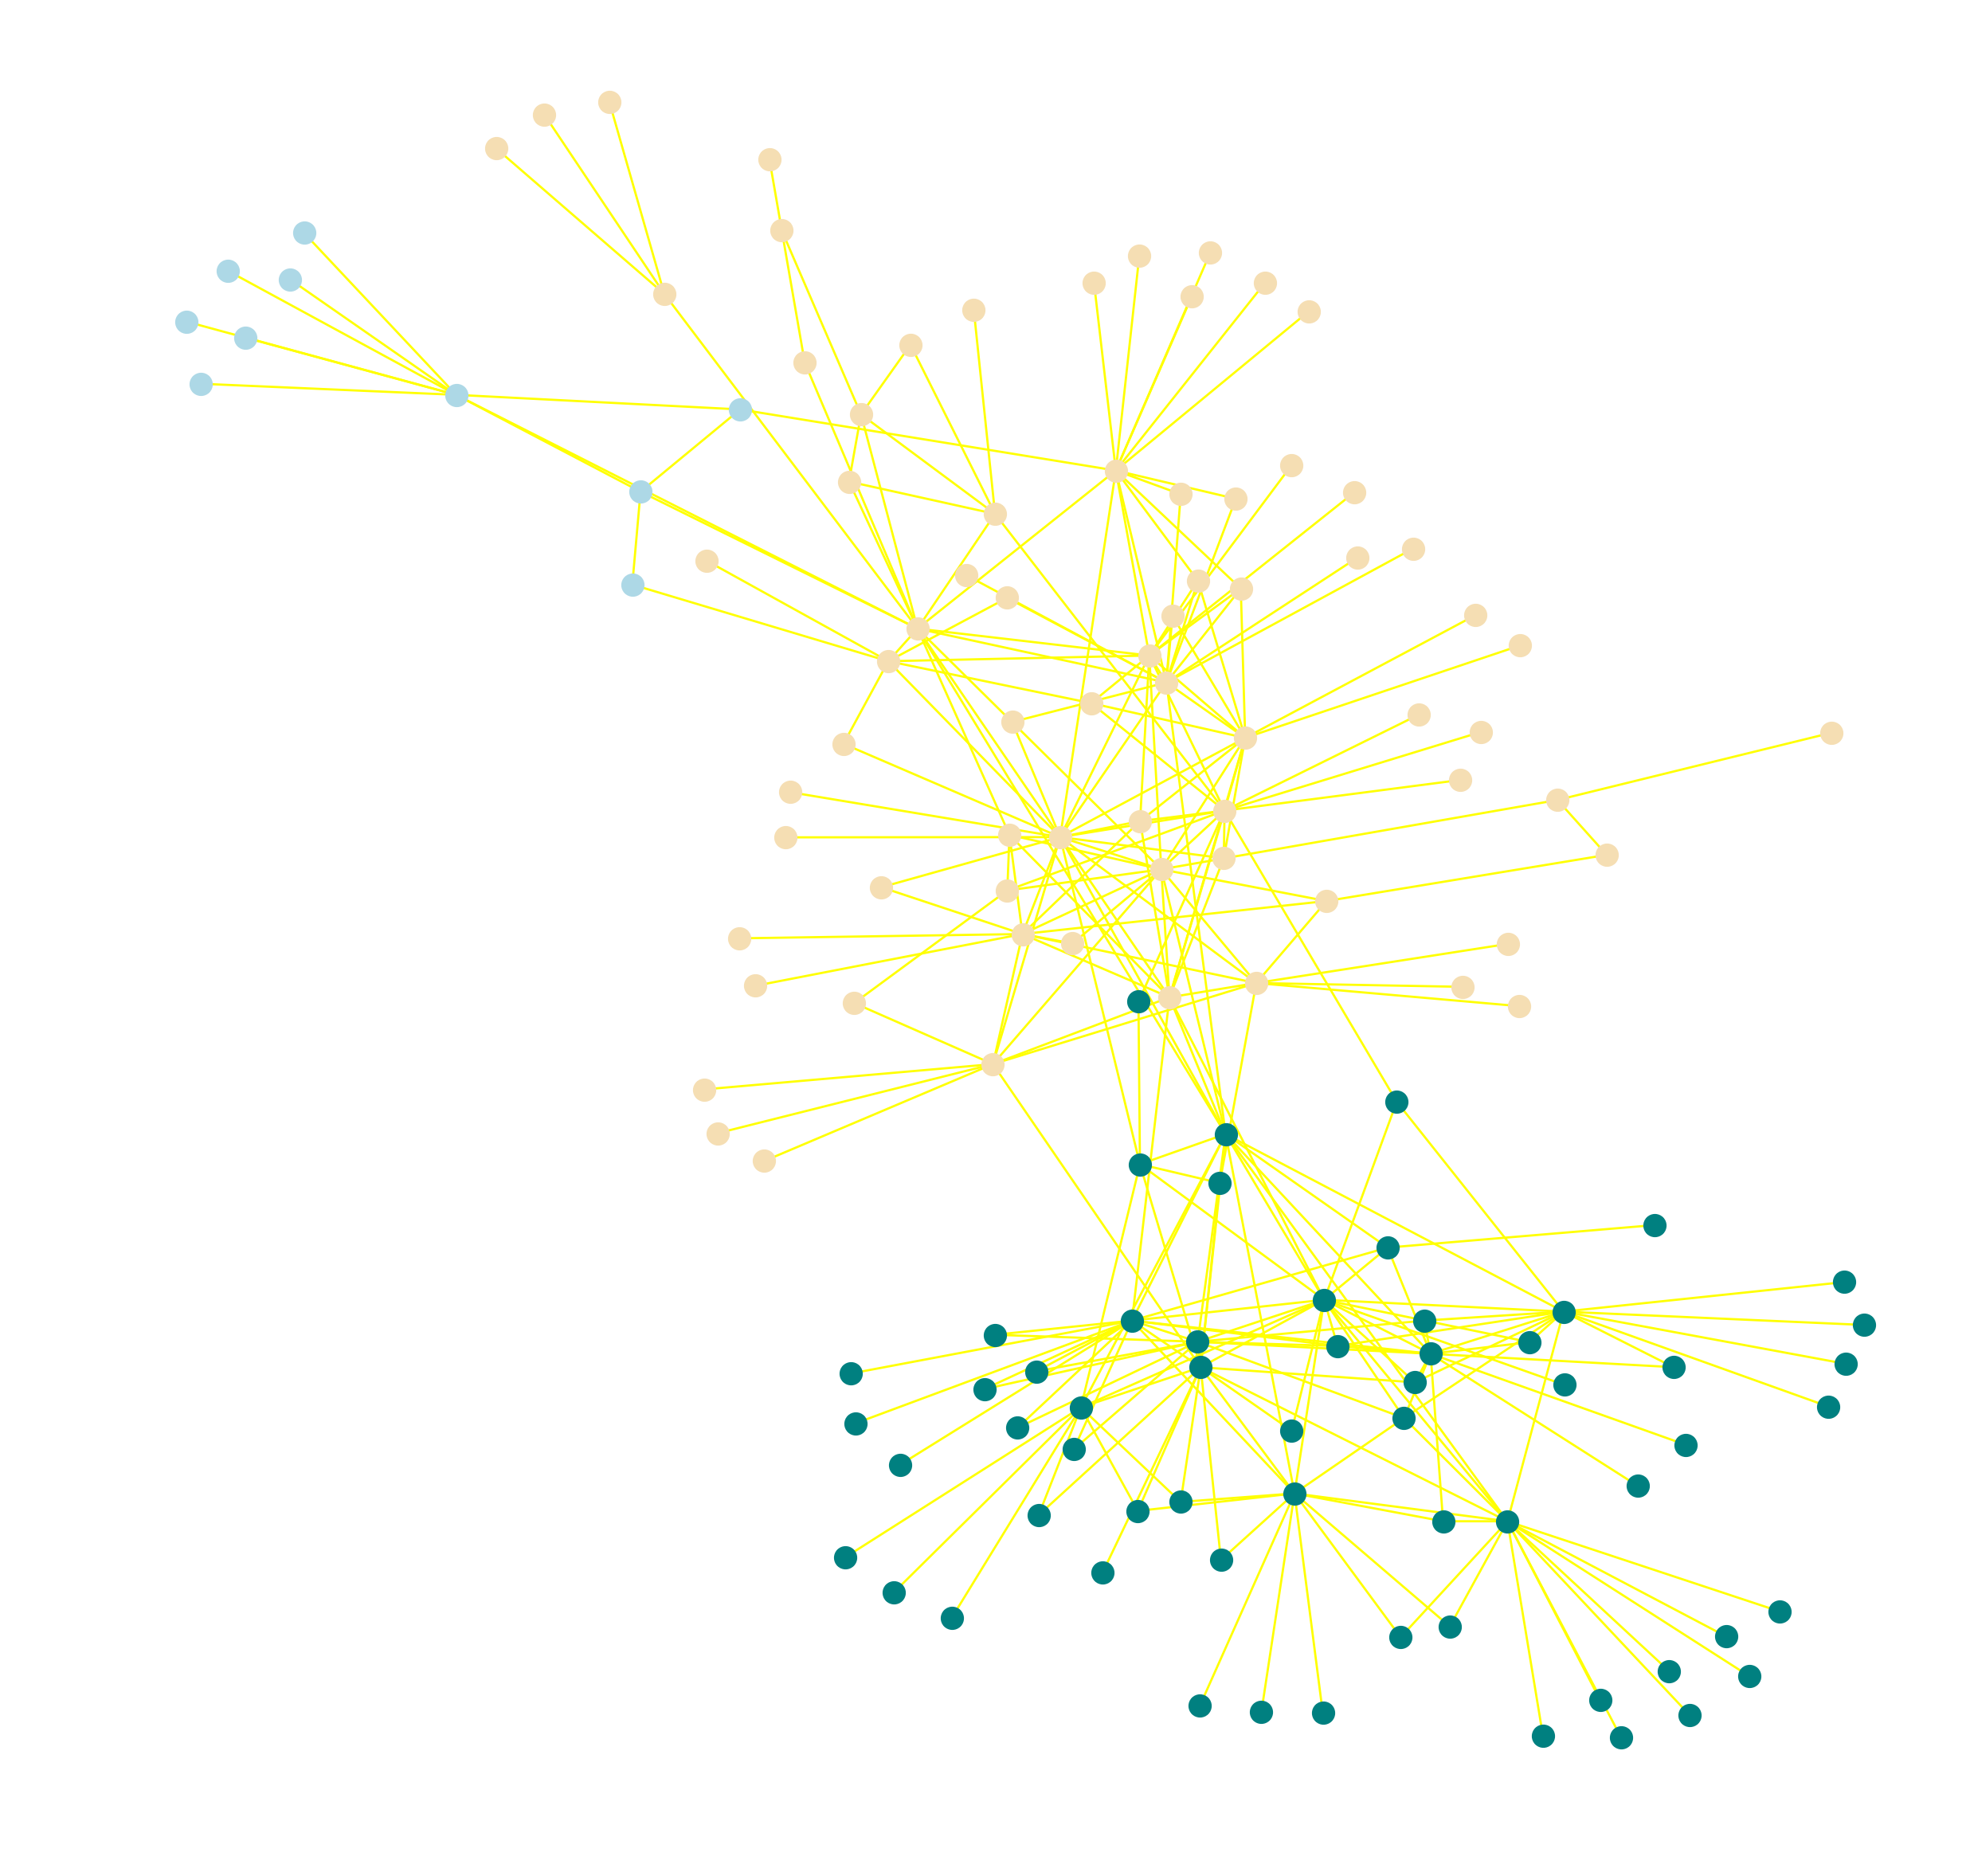

In [52]:
def main():  # запускает функции
    model2vec = make_Model()
    for_words = create_Graph(model2vec)
    gragh_analize = analysis(for_words)
    communities = groups(for_words)
  #  design = design_Graph(for_words, communities)
    
main()